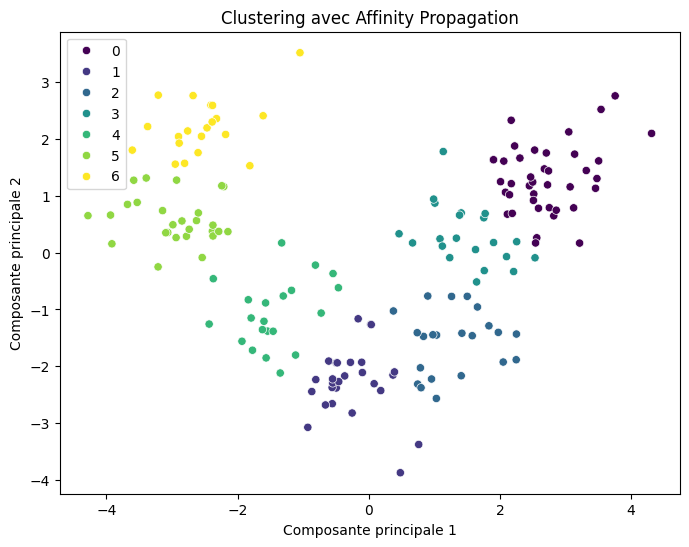

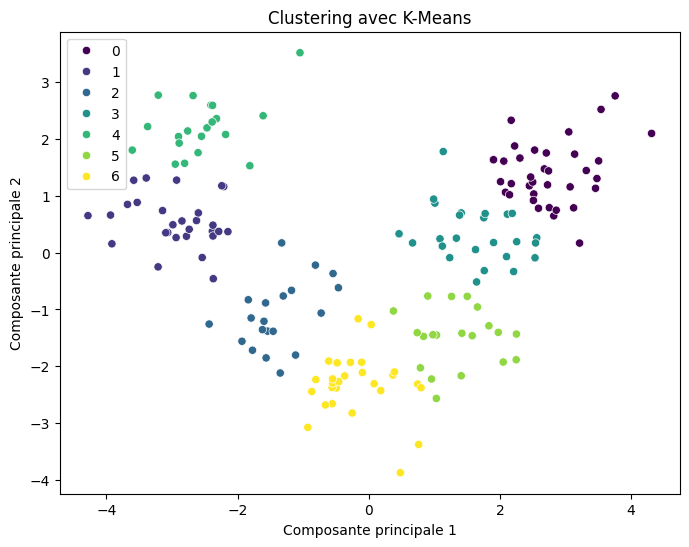

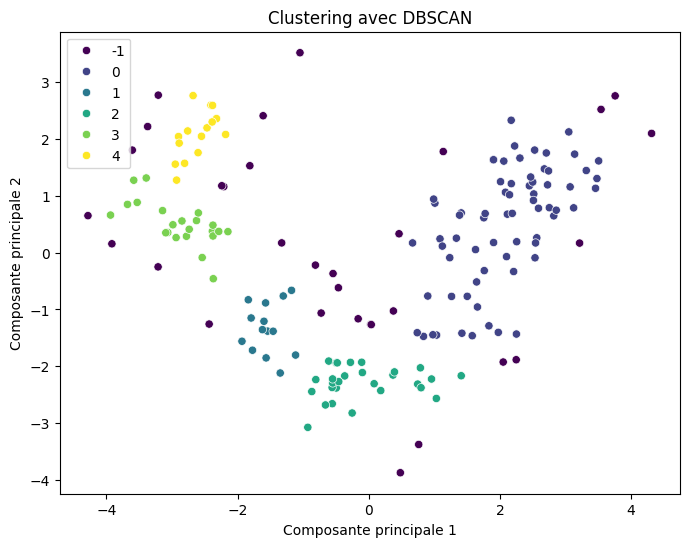

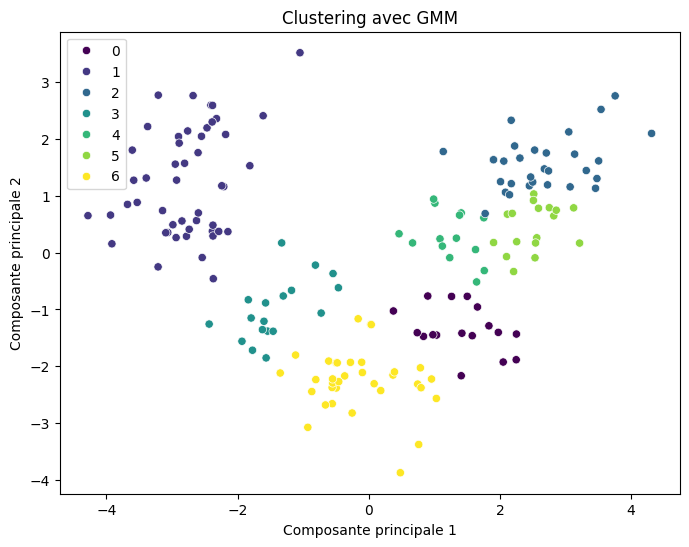


Comparaison des modèles :
------------------------------------------------------
Méthode		Silhouette Score	Accuracy
Affinity Propagation	0.4230		0.5112
K-Means	0.4222		0.5169
DBSCAN	0.5232		0.6939
GMM	0.3863		0.6236


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from scipy.optimize import linear_sum_assignment

# Projet 7 : Clustering basé sur les Graphes avec Affinity Propagation
# Partie 1 : Comprendre Affinity Propagation
# - Fonctionnement et intuition : échange de messages entre points pour identifier les exemplars.
# - Comparaison avec K-Means, DBSCAN et GMM :
#   - K-Means est rapide mais nécessite un nombre de clusters défini.
#   - DBSCAN est basé sur la densité et identifie les anomalies.
#   - GMM prend en compte des distributions gaussiennes pour gérer des clusters non sphériques.
# - Applications : utilisé en bioinformatique, reconnaissance faciale, segmentation d'images.
# - Avantages :
#   - Détecte des structures complexes.
#   - Pas besoin de spécifier le nombre de clusters.
# - Inconvénients :
#   - Très gourmand en mémoire et en temps de calcul.
#   - Peut produire trop de clusters si mal paramétré.

# Partie 2 : Application Pratique
# - Jeu de données étiqueté : dataset Wine
# - Comparaison des méthodes de clustering : Affinity Propagation, K-Means, DBSCAN, GMM
# - Évaluation : Silhouette Score et Accuracy

# Chargement du dataset (dataset Wine comme exemple de données étiquetées)
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
y_true = data.target  # Les étiquettes réelles pour comparer le clustering

# Sélection des caractéristiques numériques pour le clustering
features = df.columns.tolist()
X = df[features].dropna()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de la dimensionnalité si nécessaire
if X_scaled.shape[1] > 2:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
else:
    X_pca = X_scaled

# Fonction pour calculer l'accuracy basée sur le meilleur appariement des clusters
def clustering_accuracy(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / np.sum(cm)

# Stockage des résultats du clustering
clustering_results = {}

# Fonction pour afficher les clusters
def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette="viridis", legend="full")
    plt.title(title)
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.show()

# Application de Affinity Propagation
affinity_propagation = AffinityPropagation(damping=0.9, max_iter=500, random_state=42)
affinity_labels = affinity_propagation.fit_predict(X_pca)
silhouette_affinity = silhouette_score(X_pca, affinity_labels) if len(set(affinity_labels)) > 1 else np.nan
accuracy_affinity = clustering_accuracy(y_true, affinity_labels)
clustering_results["Affinity Propagation"] = (silhouette_affinity, accuracy_affinity)
plot_clusters(X_pca, affinity_labels, "Clustering avec Affinity Propagation")

# Application de K-Means
n_clusters = len(set(affinity_labels)) if len(set(affinity_labels)) > 1 else 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)
accuracy_kmeans = clustering_accuracy(y_true, kmeans_labels)
clustering_results["K-Means"] = (silhouette_kmeans, accuracy_kmeans)
plot_clusters(X_pca, kmeans_labels, "Clustering avec K-Means")

# Application de DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)
if len(set(dbscan_labels)) > 1:
    silhouette_dbscan = silhouette_score(X_pca[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    accuracy_dbscan = clustering_accuracy(y_true[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    silhouette_dbscan = np.nan
    accuracy_dbscan = np.nan
clustering_results["DBSCAN"] = (silhouette_dbscan, accuracy_dbscan)
plot_clusters(X_pca, dbscan_labels, "Clustering avec DBSCAN")

# Application du Modèle de Mélange Gaussien (GMM)
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)
silhouette_gmm = silhouette_score(X_pca, gmm_labels)
accuracy_gmm = clustering_accuracy(y_true, gmm_labels)
clustering_results["GMM"] = (silhouette_gmm, accuracy_gmm)
plot_clusters(X_pca, gmm_labels, "Clustering avec GMM")

# Affichage des évaluations du clustering
print("\nComparaison des modèles :")
print("------------------------------------------------------")
print("Méthode\t\tSilhouette Score\tAccuracy")
for method, scores in clustering_results.items():
    print(f"{method}\t{scores[0]:.4f}\t\t{scores[1]:.4f}")